# Quant Analysis
### statistical arbitrage strategy

Select pairs of stocks based on correlation and cointegration, and then apply a statistical arbitrage strategy on the selected pair. Adjust the tickers, date range, and thresholds as needed

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

Define a function to download historical closing prices for given stock tickers and retrieve data for multiple Thai stocks within a specified date range

In [2]:
# Define function to download stock data
def download_stock_data(tickers, start_date, end_date):
    return yf.download(tickers, start=start_date, end=end_date)['Close']

# Define function to test cointegration
def check_cointegration(stock1, stock2):
    score, p_value, _ = coint(stock1, stock2)
    return p_value

# Define function to calculate the spread
def calculate_spread(stock1, stock2, model):
    spread = stock1 - model.params[1] * stock2
    return spread

# Define function to plot spread
def plot_spread(spread, entry_threshold, exit_threshold):
    plt.figure(figsize=(12, 6))
    plt.plot(spread, label='Spread')
    plt.axhline(entry_threshold, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(-entry_threshold, color='green', linestyle='--', label='Exit Threshold')
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.title('Spread between two stocks')
    plt.show()

# Define function to backtest pairs trading strategy with stock names
def backtest_pairs_trading_with_names(stock1, stock2, entry_threshold=2.0, exit_threshold=0.5, stock1_name='Stock 1', stock2_name='Stock 2'):
    model = sm.OLS(stock1, sm.add_constant(stock2)).fit()
    spread = calculate_spread(stock1, stock2, model)
    spread_mean = spread.mean()
    spread_std = spread.std()

    stock1_positions = []
    stock2_positions = []
    cash = 0

    for i in range(len(spread)):
        if spread[i] > spread_mean + entry_threshold * spread_std:
            stock1_positions.append(-1)
            stock2_positions.append(1)
            cash += stock1[i] - stock2[i]
        elif spread[i] < spread_mean - entry_threshold * spread_std:
            stock1_positions.append(1)
            stock2_positions.append(-1)
            cash += stock2[i] - stock1[i]
        elif abs(spread[i] - spread_mean) < exit_threshold * spread_std:
            stock1_positions.append(0)
            stock2_positions.append(0)
        else:
            stock1_positions.append(stock1_positions[-1] if stock1_positions else 0)
            stock2_positions.append(stock2_positions[-1] if stock2_positions else 0)

    stock1_positions = pd.Series(stock1_positions, index=spread.index)
    stock2_positions = pd.Series(stock2_positions, index=spread.index)

    plt.figure(figsize=(12, 6))
    plt.plot(stock1_positions, label=f'{stock1_name} Positions')
    plt.plot(stock2_positions, label=f'{stock2_name} Positions')
    plt.legend()
    plt.title('Trading Positions')
    plt.xlabel('Date')
    plt.ylabel('Position')
    plt.xticks(rotation=45)
    plt.show()

    portfolio_value = stock1_positions * stock1 + stock2_positions * stock2 + cash
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_value, label='Portfolio Value')
    plt.legend()
    plt.title('Portfolio Value over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.xticks(rotation=45)
    plt.show()

    return portfolio_value





In [3]:
# Parameters
tickers = ['TISCO.BK', 'KKP.BK', 'KGI.BK', 'SHR.BK', 'LH.BK', 'LPN.BK']  # Example tickers for Thai stocks
start_date = '2023-01-01'
end_date = '2024-05-25'
entry_threshold = 2.0
exit_threshold = 0.5

# Download stock data
data = download_stock_data(tickers, start_date, end_date)

[*********************100%%**********************]  6 of 6 completed


Calculate the correlation matrix for the stock data to identify pairs with high correlation. High correlation indicates that the stocks tend to move together historically

For each pair of stocks with high correlation, perform a cointegration test to check if they are cointegrated. Cointegration suggests that the pair has a long-term equilibrium relationship and the spread between them is mean-reverting.

Then, choose a pair from the identified potential pairs for trading.

In [4]:
# Calculate correlation matrix
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Identify pairs with high correlation and test for cointegration
potential_pairs = []
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        stock1 = data.iloc[:, i]
        stock2 = data.iloc[:, j]
        correlation = correlation_matrix.iloc[i, j]
        if correlation > 0.8:  # Arbitrary threshold for high correlation
            p_value = check_cointegration(stock1, stock2)
            if p_value < 0.05:  # Arbitrary threshold for cointegration
                potential_pairs.append((tickers[i], tickers[j], p_value))

# Print potential pairs
print("=====================================================")
print("Potential Pairs (Cointegrated with p-value < 0.05):")
for pair in potential_pairs:
    print(f"{pair[0]} and {pair[1]} with p-value: {pair[2]}")



Correlation Matrix:
Ticker      KGI.BK    KKP.BK     LH.BK    LPN.BK    SHR.BK  TISCO.BK
Ticker                                                              
KGI.BK    1.000000  0.625109  0.633803  0.401011  0.732610  0.653930
KKP.BK    0.625109  1.000000  0.889507  0.799712  0.922055  0.272684
LH.BK     0.633803  0.889507  1.000000  0.902516  0.922265  0.222729
LPN.BK    0.401011  0.799712  0.902516  1.000000  0.793631  0.056109
SHR.BK    0.732610  0.922055  0.922265  0.793631  1.000000  0.319037
TISCO.BK  0.653930  0.272684  0.222729  0.056109  0.319037  1.000000
Potential Pairs (Cointegrated with p-value < 0.05):
KKP.BK and LH.BK with p-value: 0.018845753433720292


Backtest the Trading Strategy: Implement the pairs trading strategy on the selected pair of stocks, including entry and exit rules based on the spread. Plot the trading positions and portfolio value over time to evaluate the performance of the strategy.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Selected Pair: KKP.BK and LH.BK


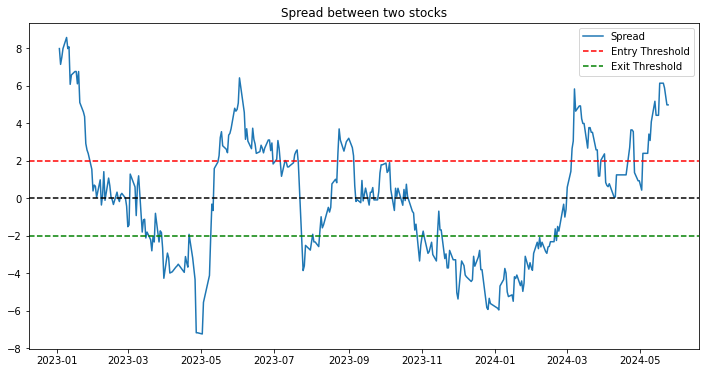

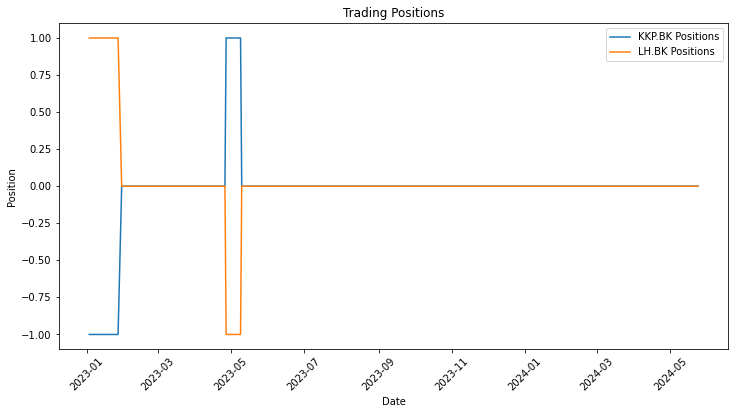

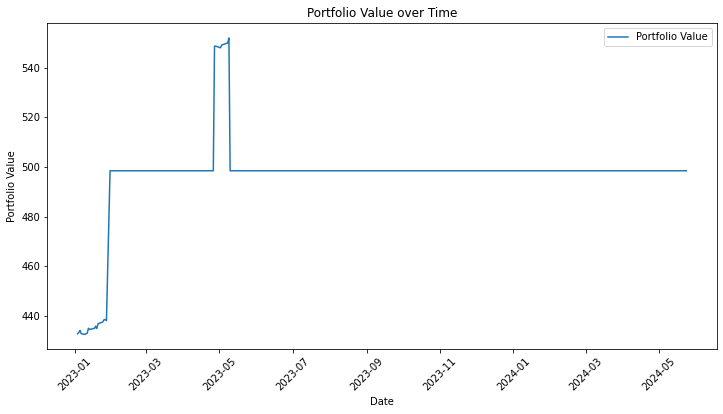

In [5]:
# Choose a pair for trading
if potential_pairs:
    selected_pair = potential_pairs[0]  # Select the first pair
    print(f"Selected Pair: {selected_pair[0]} and {selected_pair[1]}")

    # Download data for selected pair
    stock1 = download_stock_data(selected_pair[0], start_date, end_date)
    stock2 = download_stock_data(selected_pair[1], start_date, end_date)

    # Align indices of the two stock series
    aligned_data = pd.concat([stock1, stock2], axis=1).dropna()
    stock1 = aligned_data.iloc[:, 0]
    stock2 = aligned_data.iloc[:, 1]

    # Plot spread
    model = sm.OLS(stock1, sm.add_constant(stock2)).fit()
    spread = calculate_spread(stock1, stock2, model)
    plot_spread(spread, entry_threshold, exit_threshold)


    # Backtest pairs trading strategy
    portfolio_value=backtest_pairs_trading_with_names(stock1, stock2, entry_threshold, exit_threshold, selected_pair[0], selected_pair[1])


else:
    print("No suitable pairs found.")